In [1]:
import pandas as pd
import numpy as np
import torch as th
import zipfile
from tqdm.auto import tqdm, trange
from glob import glob
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
import torch_geometric as pyg
import zipfile, os
import torch
import copy
from torch import nn
import networkx as nx
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import trange
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


import torch
import torch_geometric
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import MessagePassing
from torch.nn import Sequential as Seq, Linear, ReLU, Sigmoid
import torch.optim as optim
import joblib
import gc
from scipy.optimize import root_scalar

pd.set_option("display.max_columns", 100)
PATH_DATA0 = './data/00.01'
PATH_DATA = './data/00.03'
RANDOM_SEED =0
np.random.seed(RANDOM_SEED)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Using device: cuda


# Hyperparameters

In [2]:
CRITERION = nn.BCEWithLogitsLoss()
LR = 0.001
TOLERANCE = 20
LR_TOLERANCE= 5
MAX_EPOCHS = 200
BATCH_SIZE =2

# Loaders

In [3]:
loader_train = pyg.loader.DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_train.pkl')).tolist(),
    batch_size = BATCH_SIZE,shuffle = True)
loader_val = pyg.loader.DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_val.pkl')).tolist(),batch_size = BATCH_SIZE
    ,shuffle = False)
loader_test = pyg.loader.DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_test.pkl')).tolist(),batch_size = BATCH_SIZE
    ,shuffle = False)

# Model Architecture

In [3]:
class RelationalModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RelationalModel, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, m):
        return self.layers(m)

class ObjectModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ObjectModel, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, C):
        return self.layers(C)

class InteractionConv(MessagePassing):
    def __init__(self, node_size=3, edge_size=4, node_output_size=3,edge_output_size=4, hidden_size=32):
        super(InteractionConv, self).__init__(aggr='add', 
                                                 flow='source_to_target')  
        self.R1 = RelationalModel(2*node_size+edge_size, edge_output_size, hidden_size)
        self.O = ObjectModel(node_size+edge_output_size, node_output_size, hidden_size)
        self.E: Tensor = Tensor()
        
    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:

        # propagate_type: (x: Tensor, edge_attr: Tensor)
        x_tilde = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=None)

        return x_tilde, edge_index, self.E

    def message(self, x_i, x_j, edge_attr):
        # x_i --> incoming
        # x_j --> outgoing        
        m1 = torch.cat([x_i, x_j, edge_attr], dim=1)
        self.E = self.R1(m1)
        return self.E

    def update(self, aggr_out, x):
        c = torch.cat([x, aggr_out], dim=1)
        c = self.O(c)
        return c
        
class InteractionNetwork(nn.Module):
    def __init__(self, hidden_size, n_layers):
        super().__init__()
        self.n_layers = n_layers
        for i in range(1, n_layers+1):
            setattr(self, f'conv{i}',InteractionConv(node_size=3 if i==1 else hidden_size, edge_size=4 if i==1 else hidden_size, 
                                                     node_output_size=hidden_size,
                                     edge_output_size=hidden_size, hidden_size=hidden_size))
        self.R2 = RelationalModel(hidden_size*3, 1, hidden_size)
        self.E: Tensor = Tensor()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:

        # propagate_type: (x: Tensor, edge_attr: Tensor)
        for i in range(1, self.n_layers+1):
            x, edge_index, edge_attr = getattr(self, f'conv{i}')(x, edge_index, edge_attr)

        m2 = torch.cat([x[edge_index[1]],
                        x[edge_index[0]],
                        edge_attr], dim=1)
        return self.R2(m2)



# Functions

In [4]:
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return trainable_params
def evaluate(model, loader):
    model.eval()
    preds, actuals = [],[]
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds.append(torch.sigmoid(model(batch.x, batch.edge_index, batch.edge_attr)))
            actuals.append(batch.y)
        preds = torch.cat(preds)
        actuals = torch.cat(actuals)
        acc = ((preds>0.5)==(actuals>0.5)).type(torch.float).mean().item()
        entropy = CRITERION(preds, actuals.float()).item()
    model.train()
    return preds.cpu().numpy(), actuals.cpu().numpy(), acc, entropy
def train_epoch(model, loader_train,optimizer):
    model.train()
    train_loss = 0.0
    for batch in tqdm(loader_train, leave = False):
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch.x, batch.edge_index, batch.edge_attr)
        loss = CRITERION(output, batch.y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(loader_train)    
    return train_loss


# Train

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

4 1000000
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.5808 |    0.4138 |   0.9291 |    0.9314 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.2233 |    0.3887 |   0.9684 |    0.9688 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.1078 |    0.3814 |   0.9830 |    0.9837 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.0710 |    0.3791 |   0.9879 |    0.9883 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.0564 |    0.3765 |   0.9909 |    0.9909 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.0423 |    0.3751 |   0.9925 |    0.9927 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.0387 |    0.3755 |   0.9918 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.0352 |    0.3749 |   0.9929 |    0.9930 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.0354 |    0.3741 |   0.9944 |    0.9945 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.0298 |    0.3743 |   0.9937 |    0.9939


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.0281 |    0.3739 |   0.9951 |    0.9952 *


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.0240 |    0.3745 |   0.9942 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.0234 |    0.3731 |   0.9959 |    0.9959 *


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.0253 |    0.3733 |   0.9954 |    0.9958


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.0204 |    0.3731 |   0.9960 |    0.9961 *


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.0198 |    0.3727 |   0.9965 |    0.9965 *


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.0221 |    0.3739 |   0.9948 |    0.9947


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.0196 |    0.3727 |   0.9963 |    0.9963


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.0162 |    0.3727 |   0.9965 |    0.9967 *


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.0162 |    0.3723 |   0.9969 |    0.9968 *


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.0178 |    0.3727 |   0.9966 |    0.9966


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.0155 |    0.3722 |   0.9972 |    0.9973 *


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.0152 |    0.3726 |   0.9966 |    0.9967


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.0174 |    0.3728 |   0.9963 |    0.9962


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.0149 |    0.3722 |   0.9972 |    0.9972


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.0152 |    0.3719 |   0.9975 |    0.9974 *


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.0150 |    0.3719 |   0.9975 |    0.9975


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.0148 |    0.3725 |   0.9968 |    0.9970


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.0128 |    0.3723 |   0.9973 |    0.9975


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.0120 |    0.3722 |   0.9973 |    0.9975


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.0121 |    0.3721 |   0.9972 |    0.9973
LR reduction to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.0134 |    0.3722 |   0.9971 |    0.9971
LR reduction to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.0121 |    0.3723 |   0.9972 |    0.9974
LR reduction to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.0125 |    0.3721 |   0.9975 |    0.9976
LR reduction to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.0107 |    0.3719 |   0.9975 |    0.9976
LR reduction to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.0123 |    0.3719 |   0.9977 |    0.9978 *


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.0100 |    0.3720 |   0.9976 |    0.9977


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.0103 |    0.3720 |   0.9975 |    0.9977


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.0106 |    0.3720 |   0.9977 |    0.9977


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.0099 |    0.3719 |   0.9976 |    0.9977


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.0093 |    0.3719 |   0.9979 |    0.9980
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.0145 |    0.3716 |   0.9980 |    0.9981 *


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.0101 |    0.3717 |   0.9980 |    0.9981


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.0091 |    0.3717 |   0.9979 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.0106 |    0.3718 |   0.9979 |    0.9981


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.0089 |    0.3717 |   0.9980 |    0.9980


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.0077 |    0.3715 |   0.9983 |    0.9982 *


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.0093 |    0.3718 |   0.9978 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.0093 |    0.3719 |   0.9976 |    0.9976


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.0088 |    0.3716 |   0.9981 |    0.9981


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.0069 |    0.3716 |   0.9981 |    0.9982


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.0089 |    0.3720 |   0.9979 |    0.9978
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.0088 |    0.3718 |   0.9980 |    0.9979
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.0089 |    0.3718 |   0.9978 |    0.9978
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.0083 |    0.3719 |   0.9976 |    0.9978
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.0074 |    0.3719 |   0.9979 |    0.9980
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.0115 |    0.3728 |   0.9969 |    0.9967
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.0098 |    0.3720 |   0.9977 |    0.9977
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.0080 |    0.3716 |   0.9981 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.0072 |    0.3715 |   0.9983 |    0.9983 *


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.0062 |    0.3713 |   0.9984 |    0.9984 *


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.0080 |    0.3717 |   0.9980 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.0078 |    0.3717 |   0.9981 |    0.9982


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.0076 |    0.3716 |   0.9981 |    0.9982


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.0075 |    0.3717 |   0.9978 |    0.9978


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.0072 |    0.3716 |   0.9981 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.0068 |    0.3715 |   0.9981 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.0081 |    0.3717 |   0.9980 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.0065 |    0.3715 |   0.9983 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.0052 |    0.3714 |   0.9984 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.0077 |    0.3716 |   0.9983 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.0066 |    0.3715 |   0.9983 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.0089 |    0.3716 |   0.9981 |    0.9978
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.0068 |    0.3714 |   0.9984 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.0056 |    0.3714 |   0.9984 |    0.9985
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.0054 |    0.3714 |   0.9984 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.0078 |    0.3715 |   0.9983 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.0073 |    0.3718 |   0.9976 |    0.9976
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.0078 |    0.3714 |   0.9983 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.0079 |    0.3716 |   0.9982 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.0066 |    0.3738 |   0.9952 |    0.9954
Early stopping at epoch 81


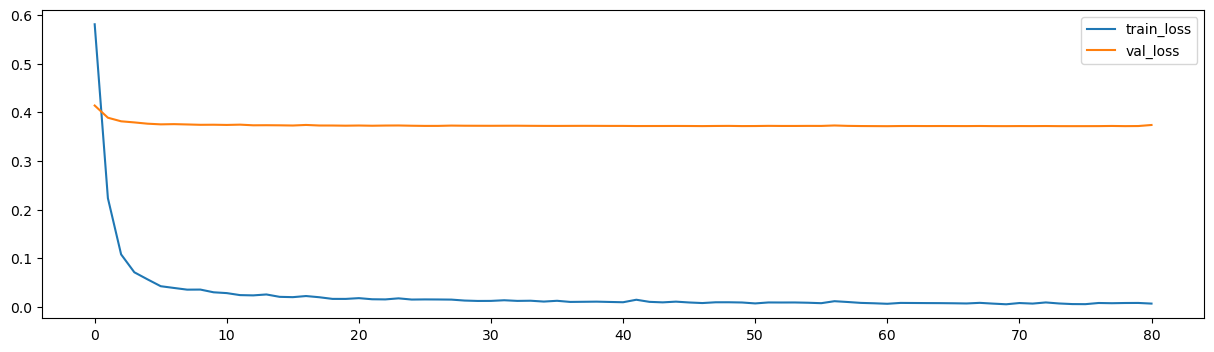

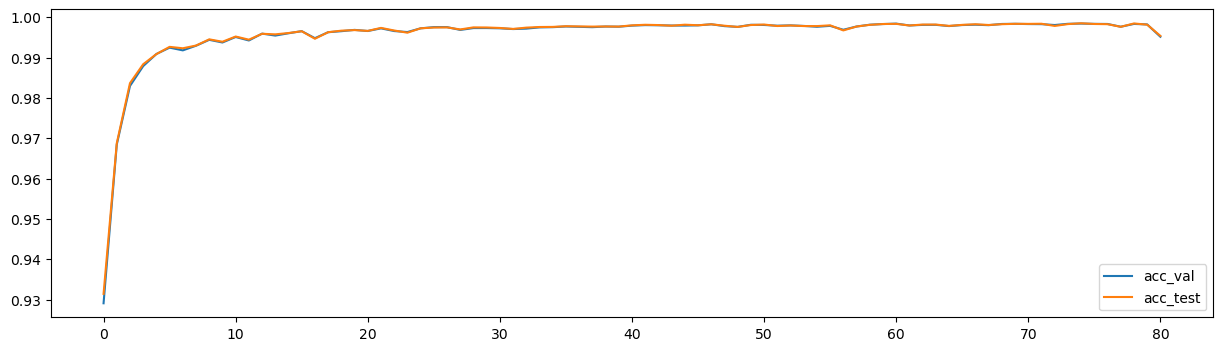

4 100000
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.6380 |    0.4468 |   0.8684 |    0.8719 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.3937 |    0.4028 |   0.9466 |    0.9486 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.1957 |    0.3918 |   0.9666 |    0.9680 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.1368 |    0.3850 |   0.9779 |    0.9782 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.1105 |    0.3827 |   0.9817 |    0.9824 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.0894 |    0.3805 |   0.9843 |    0.9847 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.0796 |    0.3795 |   0.9859 |    0.9858 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.0712 |    0.3778 |   0.9879 |    0.9881 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.0628 |    0.3782 |   0.9889 |    0.9890


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.0603 |    0.3778 |   0.9882 |    0.9883


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.0518 |    0.3766 |   0.9902 |    0.9903 *


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.0491 |    0.3762 |   0.9913 |    0.9919 *


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.0456 |    0.3753 |   0.9920 |    0.9921 *


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.0479 |    0.3757 |   0.9921 |    0.9922


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.0391 |    0.3748 |   0.9930 |    0.9932 *


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.0370 |    0.3747 |   0.9935 |    0.9936 *


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.0367 |    0.3754 |   0.9931 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.0333 |    0.3742 |   0.9940 |    0.9942 *


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.0331 |    0.3744 |   0.9939 |    0.9941


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.0317 |    0.3750 |   0.9929 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.0294 |    0.3753 |   0.9933 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.0288 |    0.3743 |   0.9942 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.0273 |    0.3748 |   0.9938 |    0.9937
LR reduction to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.0271 |    0.3739 |   0.9946 |    0.9945 *


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.0260 |    0.3735 |   0.9956 |    0.9956 *


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.0250 |    0.3734 |   0.9955 |    0.9956 *


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.0234 |    0.3738 |   0.9949 |    0.9951


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.0241 |    0.3735 |   0.9952 |    0.9952


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.0232 |    0.3734 |   0.9952 |    0.9952 *


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.0210 |    0.3734 |   0.9957 |    0.9958 *


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.0224 |    0.3729 |   0.9961 |    0.9961 *


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.0209 |    0.3733 |   0.9955 |    0.9955


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.0208 |    0.3727 |   0.9964 |    0.9964 *


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.0215 |    0.3731 |   0.9960 |    0.9960


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.0191 |    0.3731 |   0.9961 |    0.9958


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.0188 |    0.3727 |   0.9963 |    0.9965 *


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.0186 |    0.3737 |   0.9952 |    0.9949


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.0178 |    0.3728 |   0.9965 |    0.9965


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.0181 |    0.3727 |   0.9963 |    0.9963


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.0183 |    0.3729 |   0.9962 |    0.9963


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.0162 |    0.3729 |   0.9960 |    0.9960
LR reduction to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.0180 |    0.3727 |   0.9965 |    0.9967 *


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.0163 |    0.3727 |   0.9968 |    0.9966


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.0162 |    0.3725 |   0.9967 |    0.9968 *


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.0147 |    0.3726 |   0.9966 |    0.9965


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.0159 |    0.3723 |   0.9970 |    0.9970 *


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.0163 |    0.3727 |   0.9965 |    0.9964


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.0137 |    0.3721 |   0.9973 |    0.9972 *


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.0149 |    0.3726 |   0.9969 |    0.9969


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.0141 |    0.3722 |   0.9971 |    0.9972


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.0148 |    0.3725 |   0.9968 |    0.9967


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.0144 |    0.3727 |   0.9965 |    0.9965


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.0130 |    0.3721 |   0.9974 |    0.9975 *


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.0129 |    0.3725 |   0.9969 |    0.9970


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.0134 |    0.3721 |   0.9972 |    0.9973


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.0134 |    0.3721 |   0.9974 |    0.9974


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.0126 |    0.3722 |   0.9971 |    0.9970


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.0150 |    0.3724 |   0.9970 |    0.9969
LR reduction to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.0115 |    0.3722 |   0.9973 |    0.9973
LR reduction to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.0127 |    0.3724 |   0.9969 |    0.9970
LR reduction to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.0127 |    0.3720 |   0.9975 |    0.9975 *


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.0111 |    0.3726 |   0.9966 |    0.9965


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.0111 |    0.3718 |   0.9977 |    0.9977 *


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.0111 |    0.3719 |   0.9976 |    0.9977


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.0104 |    0.3720 |   0.9977 |    0.9976


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.0099 |    0.3720 |   0.9976 |    0.9977


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.0098 |    0.3720 |   0.9974 |    0.9974


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.0113 |    0.3721 |   0.9973 |    0.9974
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.0121 |    0.3719 |   0.9976 |    0.9975
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.0103 |    0.3718 |   0.9979 |    0.9978 *


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.0098 |    0.3718 |   0.9978 |    0.9978


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.0104 |    0.3724 |   0.9973 |    0.9975


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.0094 |    0.3717 |   0.9980 |    0.9980 *


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.0101 |    0.3720 |   0.9975 |    0.9977


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.0097 |    0.3722 |   0.9972 |    0.9974


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.0093 |    0.3718 |   0.9978 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.0087 |    0.3723 |   0.9974 |    0.9974


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.0085 |    0.3720 |   0.9975 |    0.9975
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.0092 |    0.3718 |   0.9975 |    0.9975
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.0093 |    0.3721 |   0.9975 |    0.9975
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.0099 |    0.3721 |   0.9974 |    0.9974
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.0089 |    0.3717 |   0.9980 |    0.9980
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.0097 |    0.3722 |   0.9974 |    0.9974
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.0088 |    0.3718 |   0.9978 |    0.9979
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.0086 |    0.3717 |   0.9981 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.0094 |    0.3719 |   0.9976 |    0.9976
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.0086 |    0.3716 |   0.9980 |    0.9981 *


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.0077 |    0.3718 |   0.9980 |    0.9980


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.0089 |    0.3718 |   0.9977 |    0.9978


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.0082 |    0.3719 |   0.9977 |    0.9978


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.0089 |    0.3719 |   0.9977 |    0.9978


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.0085 |    0.3719 |   0.9978 |    0.9979
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.0083 |    0.3717 |   0.9980 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.0071 |    0.3716 |   0.9980 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.0079 |    0.3716 |   0.9980 |    0.9980 *


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.0074 |    0.3718 |   0.9978 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.0083 |    0.3718 |   0.9977 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.0080 |    0.3718 |   0.9977 |    0.9978


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.0090 |    0.3718 |   0.9978 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.0081 |    0.3718 |   0.9978 |    0.9978
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  101 |     0.0067 |    0.3715 |   0.9982 |    0.9982 *


  0%|          | 0/283 [00:00<?, ?it/s]

  102 |     0.0083 |    0.3716 |   0.9981 |    0.9981


  0%|          | 0/283 [00:00<?, ?it/s]

  103 |     0.0094 |    0.3719 |   0.9977 |    0.9976


  0%|          | 0/283 [00:00<?, ?it/s]

  104 |     0.0070 |    0.3716 |   0.9981 |    0.9982


  0%|          | 0/283 [00:00<?, ?it/s]

  105 |     0.0067 |    0.3717 |   0.9978 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

  106 |     0.0076 |    0.3719 |   0.9978 |    0.9979
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  107 |     0.0069 |    0.3717 |   0.9980 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  108 |     0.0067 |    0.3717 |   0.9979 |    0.9980
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  109 |     0.0088 |    0.3721 |   0.9972 |    0.9974
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  110 |     0.0076 |    0.3715 |   0.9982 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  111 |     0.0063 |    0.3715 |   0.9983 |    0.9983 *


  0%|          | 0/283 [00:00<?, ?it/s]

  112 |     0.0070 |    0.3716 |   0.9982 |    0.9982


  0%|          | 0/283 [00:00<?, ?it/s]

  113 |     0.0093 |    0.3716 |   0.9981 |    0.9982


  0%|          | 0/283 [00:00<?, ?it/s]

  114 |     0.0058 |    0.3714 |   0.9983 |    0.9983 *


  0%|          | 0/283 [00:00<?, ?it/s]

  115 |     0.0063 |    0.3716 |   0.9981 |    0.9981


  0%|          | 0/283 [00:00<?, ?it/s]

  116 |     0.0060 |    0.3718 |   0.9977 |    0.9976


  0%|          | 0/283 [00:00<?, ?it/s]

  117 |     0.0070 |    0.3715 |   0.9982 |    0.9981


  0%|          | 0/283 [00:00<?, ?it/s]

  118 |     0.0067 |    0.3716 |   0.9982 |    0.9983


  0%|          | 0/283 [00:00<?, ?it/s]

  119 |     0.0074 |    0.3717 |   0.9980 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  120 |     0.0057 |    0.3715 |   0.9981 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  121 |     0.0062 |    0.3714 |   0.9983 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  122 |     0.0064 |    0.3717 |   0.9981 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  123 |     0.0085 |    0.3715 |   0.9982 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  124 |     0.0064 |    0.3715 |   0.9982 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  125 |     0.0058 |    0.3717 |   0.9980 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  126 |     0.0069 |    0.3715 |   0.9981 |    0.9980
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  127 |     0.0059 |    0.3715 |   0.9982 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  128 |     0.0054 |    0.3714 |   0.9984 |    0.9985 *


  0%|          | 0/283 [00:00<?, ?it/s]

  129 |     0.0063 |    0.3717 |   0.9979 |    0.9980


  0%|          | 0/283 [00:00<?, ?it/s]

  130 |     0.0063 |    0.3715 |   0.9984 |    0.9984


  0%|          | 0/283 [00:00<?, ?it/s]

  131 |     0.0071 |    0.3716 |   0.9980 |    0.9980


  0%|          | 0/283 [00:00<?, ?it/s]

  132 |     0.0064 |    0.3718 |   0.9980 |    0.9980


  0%|          | 0/283 [00:00<?, ?it/s]

  133 |     0.0068 |    0.3718 |   0.9976 |    0.9978
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  134 |     0.0056 |    0.3715 |   0.9982 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  135 |     0.0059 |    0.3715 |   0.9982 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  136 |     0.0071 |    0.3719 |   0.9974 |    0.9974
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  137 |     0.0065 |    0.3716 |   0.9981 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  138 |     0.0057 |    0.3715 |   0.9982 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  139 |     0.0060 |    0.3717 |   0.9981 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  140 |     0.0055 |    0.3714 |   0.9984 |    0.9984 *


  0%|          | 0/283 [00:00<?, ?it/s]

  141 |     0.0067 |    0.3716 |   0.9980 |    0.9982


  0%|          | 0/283 [00:00<?, ?it/s]

  142 |     0.0065 |    0.3715 |   0.9983 |    0.9983


  0%|          | 0/283 [00:00<?, ?it/s]

  143 |     0.0050 |    0.3719 |   0.9977 |    0.9976


  0%|          | 0/283 [00:00<?, ?it/s]

  144 |     0.0061 |    0.3715 |   0.9983 |    0.9984


  0%|          | 0/283 [00:00<?, ?it/s]

  145 |     0.0057 |    0.3715 |   0.9982 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  146 |     0.0051 |    0.3715 |   0.9982 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  147 |     0.0067 |    0.3716 |   0.9980 |    0.9980
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  148 |     0.0047 |    0.3713 |   0.9984 |    0.9984 *


  0%|          | 0/283 [00:00<?, ?it/s]

  149 |     0.0052 |    0.3714 |   0.9982 |    0.9983


  0%|          | 0/283 [00:00<?, ?it/s]

  150 |     0.0053 |    0.3717 |   0.9981 |    0.9982


  0%|          | 0/283 [00:00<?, ?it/s]

  151 |     0.0059 |    0.3715 |   0.9982 |    0.9981


  0%|          | 0/283 [00:00<?, ?it/s]

  152 |     0.0065 |    0.3715 |   0.9982 |    0.9984


  0%|          | 0/283 [00:00<?, ?it/s]

  153 |     0.0059 |    0.3715 |   0.9983 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  154 |     0.0072 |    0.3714 |   0.9983 |    0.9985
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  155 |     0.0050 |    0.3714 |   0.9984 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  156 |     0.0045 |    0.3714 |   0.9982 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  157 |     0.0062 |    0.3714 |   0.9983 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  158 |     0.0061 |    0.3719 |   0.9978 |    0.9978
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  159 |     0.0054 |    0.3713 |   0.9985 |    0.9985 *


  0%|          | 0/283 [00:00<?, ?it/s]

  160 |     0.0053 |    0.3714 |   0.9984 |    0.9985


  0%|          | 0/283 [00:00<?, ?it/s]

  161 |     0.0052 |    0.3714 |   0.9984 |    0.9983


  0%|          | 0/283 [00:00<?, ?it/s]

  162 |     0.0041 |    0.3714 |   0.9984 |    0.9985


  0%|          | 0/283 [00:00<?, ?it/s]

  163 |     0.0051 |    0.3716 |   0.9981 |    0.9982


  0%|          | 0/283 [00:00<?, ?it/s]

  164 |     0.0055 |    0.3715 |   0.9982 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  165 |     0.0049 |    0.3716 |   0.9981 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  166 |     0.0057 |    0.3714 |   0.9983 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  167 |     0.0071 |    0.3720 |   0.9978 |    0.9978
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  168 |     0.0060 |    0.3713 |   0.9984 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  169 |     0.0064 |    0.3716 |   0.9980 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  170 |     0.0048 |    0.3714 |   0.9984 |    0.9985
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  171 |     0.0053 |    0.3714 |   0.9983 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  172 |     0.0042 |    0.3713 |   0.9985 |    0.9986 *


  0%|          | 0/283 [00:00<?, ?it/s]

  173 |     0.0041 |    0.3713 |   0.9985 |    0.9985


  0%|          | 0/283 [00:00<?, ?it/s]

  174 |     0.0053 |    0.3714 |   0.9984 |    0.9984


  0%|          | 0/283 [00:00<?, ?it/s]

  175 |     0.0060 |    0.3716 |   0.9981 |    0.9982


  0%|          | 0/283 [00:00<?, ?it/s]

  176 |     0.0047 |    0.3713 |   0.9984 |    0.9985


  0%|          | 0/283 [00:00<?, ?it/s]

  177 |     0.0056 |    0.3714 |   0.9984 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  178 |     0.0054 |    0.3720 |   0.9973 |    0.9974
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  179 |     0.0057 |    0.3714 |   0.9984 |    0.9985
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  180 |     0.0052 |    0.3717 |   0.9981 |    0.9980
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  181 |     0.0053 |    0.3713 |   0.9985 |    0.9985
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  182 |     0.0043 |    0.3714 |   0.9984 |    0.9985
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  183 |     0.0049 |    0.3713 |   0.9986 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  184 |     0.0044 |    0.3713 |   0.9984 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  185 |     0.0048 |    0.3715 |   0.9983 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  186 |     0.0046 |    0.3718 |   0.9977 |    0.9975
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  187 |     0.0071 |    0.3716 |   0.9981 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  188 |     0.0045 |    0.3713 |   0.9984 |    0.9985
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  189 |     0.0051 |    0.3714 |   0.9985 |    0.9985
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  190 |     0.0042 |    0.3714 |   0.9982 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  191 |     0.0046 |    0.3713 |   0.9985 |    0.9985
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  192 |     0.0056 |    0.3717 |   0.9980 |    0.9981
Early stopping at epoch 192


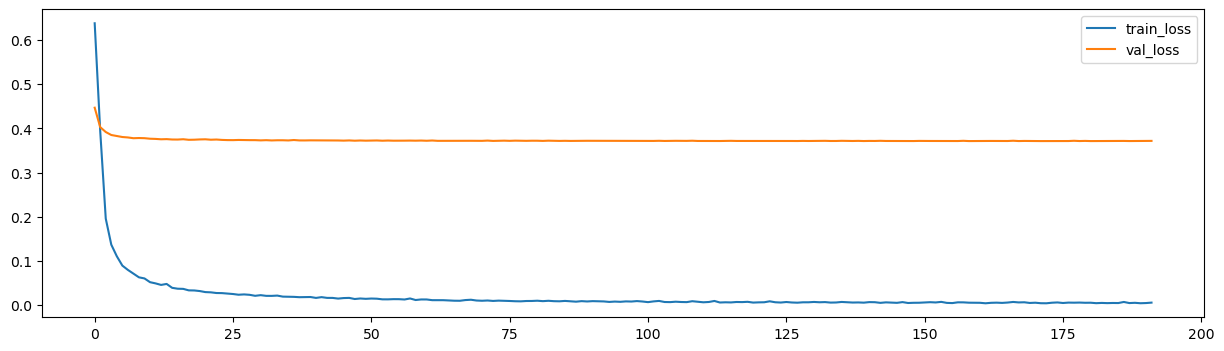

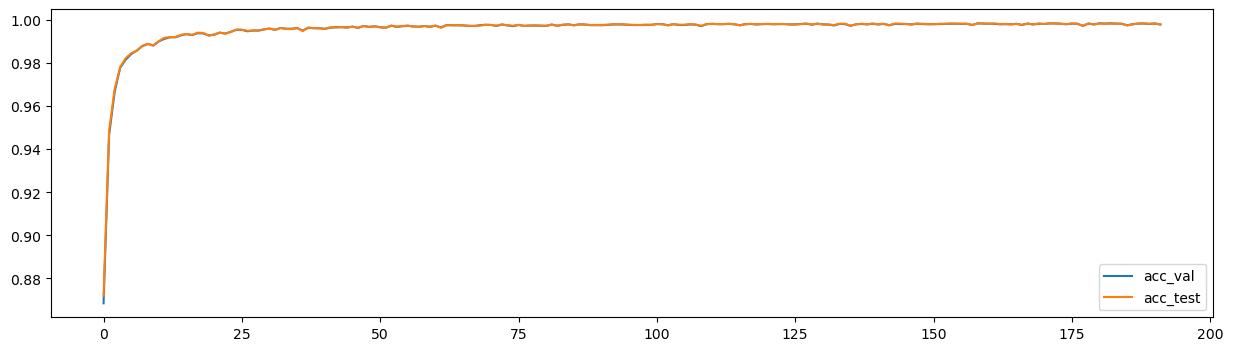

4 500000
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.5958 |    0.4291 |   0.9035 |    0.9065 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.2794 |    0.3942 |   0.9612 |    0.9620 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.1636 |    0.3882 |   0.9719 |    0.9726 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.1256 |    0.3848 |   0.9778 |    0.9785 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.1016 |    0.3817 |   0.9828 |    0.9834 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.0778 |    0.3781 |   0.9878 |    0.9879 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.0619 |    0.3777 |   0.9896 |    0.9897 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.0517 |    0.3764 |   0.9917 |    0.9918 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.0462 |    0.3760 |   0.9911 |    0.9910 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.0407 |    0.3749 |   0.9929 |    0.9931 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.0358 |    0.3752 |   0.9931 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.0316 |    0.3740 |   0.9941 |    0.9940 *


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.0311 |    0.3740 |   0.9947 |    0.9946


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.0281 |    0.3734 |   0.9953 |    0.9956 *


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.0260 |    0.3737 |   0.9948 |    0.9949


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.0242 |    0.3736 |   0.9949 |    0.9951


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.0217 |    0.3730 |   0.9958 |    0.9958 *


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.0250 |    0.3738 |   0.9947 |    0.9948


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.0206 |    0.3731 |   0.9958 |    0.9959


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.0203 |    0.3728 |   0.9966 |    0.9966 *


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.0203 |    0.3737 |   0.9954 |    0.9957


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.0183 |    0.3725 |   0.9966 |    0.9967 *


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.0177 |    0.3729 |   0.9965 |    0.9966


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.0193 |    0.3735 |   0.9959 |    0.9958


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.0181 |    0.3732 |   0.9962 |    0.9961


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.0161 |    0.3724 |   0.9968 |    0.9967 *


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.0158 |    0.3725 |   0.9968 |    0.9968


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.0179 |    0.3725 |   0.9968 |    0.9969


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.0178 |    0.3723 |   0.9970 |    0.9971 *


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.0137 |    0.3722 |   0.9971 |    0.9972 *


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.0129 |    0.3725 |   0.9970 |    0.9968


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.0138 |    0.3722 |   0.9972 |    0.9973


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.0146 |    0.3724 |   0.9970 |    0.9971


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.0144 |    0.3722 |   0.9973 |    0.9972


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.0133 |    0.3724 |   0.9971 |    0.9974
LR reduction to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.0122 |    0.3722 |   0.9975 |    0.9976
LR reduction to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.0129 |    0.3720 |   0.9975 |    0.9977 *


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.0161 |    0.3729 |   0.9964 |    0.9963


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.0118 |    0.3720 |   0.9975 |    0.9976


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.0112 |    0.3723 |   0.9972 |    0.9973


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.0147 |    0.3725 |   0.9968 |    0.9970


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.0111 |    0.3720 |   0.9975 |    0.9976
LR reduction to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.0108 |    0.3719 |   0.9976 |    0.9977 *


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.0119 |    0.3721 |   0.9974 |    0.9976


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.0116 |    0.3719 |   0.9978 |    0.9977 *


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.0097 |    0.3717 |   0.9979 |    0.9979 *


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.0101 |    0.3720 |   0.9976 |    0.9978


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.0094 |    0.3719 |   0.9977 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.0110 |    0.3719 |   0.9979 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.0100 |    0.3720 |   0.9977 |    0.9975


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.0105 |    0.3723 |   0.9974 |    0.9974
LR reduction to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.0100 |    0.3718 |   0.9976 |    0.9978
LR reduction to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.0093 |    0.3717 |   0.9980 |    0.9980 *


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.0087 |    0.3717 |   0.9977 |    0.9978


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.0089 |    0.3720 |   0.9976 |    0.9976


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.0092 |    0.3717 |   0.9978 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.0092 |    0.3719 |   0.9976 |    0.9977


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.0104 |    0.3719 |   0.9977 |    0.9977
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.0088 |    0.3719 |   0.9977 |    0.9978
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.0079 |    0.3717 |   0.9979 |    0.9980
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.0077 |    0.3717 |   0.9980 |    0.9982 *


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.0076 |    0.3721 |   0.9975 |    0.9976


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.0089 |    0.3724 |   0.9969 |    0.9970


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.0109 |    0.3719 |   0.9978 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.0085 |    0.3717 |   0.9979 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.0084 |    0.3717 |   0.9979 |    0.9980
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.0072 |    0.3716 |   0.9982 |    0.9981 *


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.0089 |    0.3718 |   0.9979 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.0072 |    0.3716 |   0.9982 |    0.9983 *


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.0083 |    0.3719 |   0.9977 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.0080 |    0.3718 |   0.9977 |    0.9977


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.0067 |    0.3717 |   0.9979 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.0077 |    0.3725 |   0.9967 |    0.9969


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.0091 |    0.3715 |   0.9982 |    0.9982 *


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.0072 |    0.3718 |   0.9980 |    0.9979


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.0070 |    0.3721 |   0.9975 |    0.9975


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.0077 |    0.3716 |   0.9980 |    0.9980


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.0064 |    0.3715 |   0.9983 |    0.9983 *


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.0073 |    0.3716 |   0.9980 |    0.9981


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.0065 |    0.3716 |   0.9980 |    0.9981


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.0066 |    0.3715 |   0.9982 |    0.9983 *


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.0051 |    0.3714 |   0.9983 |    0.9984 *


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.0067 |    0.3718 |   0.9978 |    0.9978


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.0080 |    0.3716 |   0.9980 |    0.9982


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.0067 |    0.3715 |   0.9982 |    0.9984


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.0067 |    0.3716 |   0.9981 |    0.9983


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.0059 |    0.3726 |   0.9967 |    0.9968
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.0074 |    0.3715 |   0.9983 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.0076 |    0.3717 |   0.9980 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.0069 |    0.3715 |   0.9981 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.0065 |    0.3717 |   0.9981 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.0060 |    0.3718 |   0.9977 |    0.9978
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.0060 |    0.3717 |   0.9981 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.0050 |    0.3714 |   0.9984 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.0056 |    0.3716 |   0.9981 |    0.9980
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.0057 |    0.3715 |   0.9983 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.0068 |    0.3720 |   0.9978 |    0.9978
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.0053 |    0.3713 |   0.9985 |    0.9985 *


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.0048 |    0.3714 |   0.9984 |    0.9985


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.0052 |    0.3714 |   0.9983 |    0.9984


  0%|          | 0/283 [00:00<?, ?it/s]

  101 |     0.0081 |    0.3727 |   0.9967 |    0.9969


  0%|          | 0/283 [00:00<?, ?it/s]

  102 |     0.0086 |    0.3721 |   0.9973 |    0.9973


  0%|          | 0/283 [00:00<?, ?it/s]

  103 |     0.0065 |    0.3714 |   0.9983 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  104 |     0.0050 |    0.3714 |   0.9984 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  105 |     0.0053 |    0.3715 |   0.9982 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  106 |     0.0048 |    0.3714 |   0.9984 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  107 |     0.0053 |    0.3714 |   0.9983 |    0.9982
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  108 |     0.0064 |    0.3715 |   0.9982 |    0.9981
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  109 |     0.0070 |    0.3717 |   0.9981 |    0.9979
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  110 |     0.0063 |    0.3714 |   0.9984 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  111 |     0.0045 |    0.3715 |   0.9982 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  112 |     0.0047 |    0.3717 |   0.9979 |    0.9979
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  113 |     0.0049 |    0.3714 |   0.9983 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  114 |     0.0052 |    0.3715 |   0.9982 |    0.9983
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  115 |     0.0068 |    0.3720 |   0.9978 |    0.9979
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  116 |     0.0052 |    0.3714 |   0.9984 |    0.9985
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  117 |     0.0065 |    0.3714 |   0.9984 |    0.9984
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  118 |     0.0049 |    0.3714 |   0.9982 |    0.9983
Early stopping at epoch 118


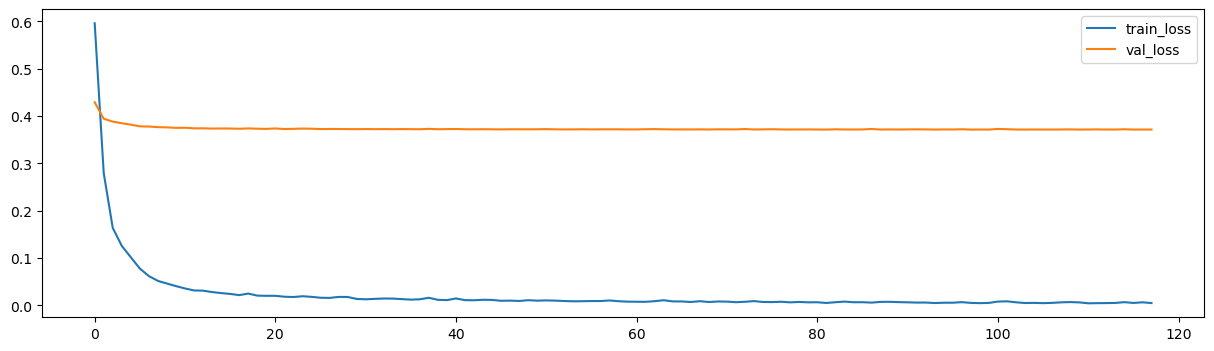

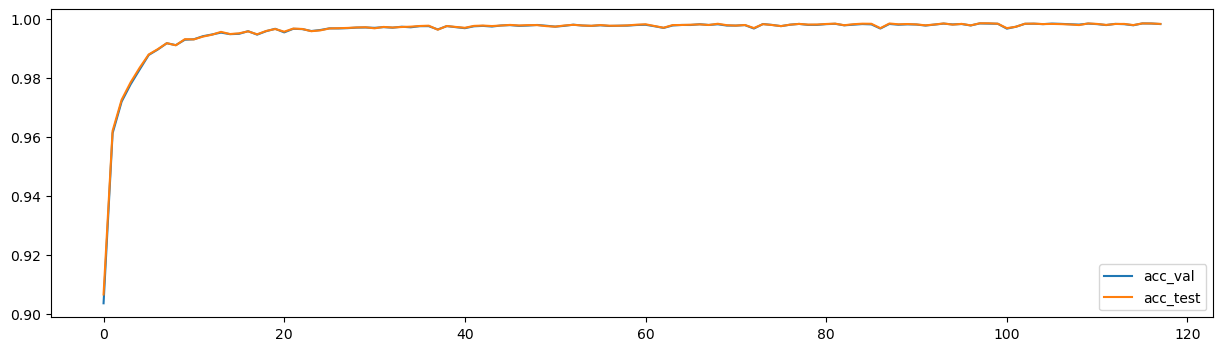

[None, None, None]

In [6]:
def f(n_layers,target_params):
    gc.collect()
    torch.cuda.empty_cache()
    print(n_layers, target_params)
    # Find out the hyperparameteres yielding #params = target_params
    def objective(h):
        return count_parameters(InteractionNetwork(int(h),n_layers)) - target_params
    optimal_h = int(root_scalar(objective, bracket=[1, 1000], method='bisect').root)
    optimal_h= pd.Series({optimal_h:target_params-count_parameters(InteractionNetwork(optimal_h, n_layers)),
                optimal_h-1:target_params-count_parameters(InteractionNetwork(optimal_h-1,n_layers)),
                optimal_h+1:target_params-count_parameters(InteractionNetwork(optimal_h+1,n_layers))}).abs().idxmin()
    
    model = InteractionNetwork(optimal_h,n_layers).to(device)
    lr = LR
    optimizer = optim.Adam(model.parameters(), lr=LR)
    best_val_loss = float('inf')
    epochs_no_improve, epochs_no_improve2 = 0,0
    best_model_state = None
    stats = []
    best = None
    # Print header once
    print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Val Loss':>9} | {'Val Acc':>8} | {'Test Acc':>9}")
    print("-" * 50)
    for epoch in trange(MAX_EPOCHS):
        train_loss = train_epoch(model, loader_train, optimizer)   
        preds_val, actuals_val, acc_val, val_loss = evaluate(model,loader_val)
        preds_test, actuals_test, acc_test, test_loss = evaluate(model,loader_test)
        
        stats.append({'train_loss':train_loss, 'val_loss':val_loss, 'acc_val':acc_val, 'acc_test':acc_test})
        if val_loss < best_val_loss: 
            print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f} *")
            best_val_loss = val_loss
            epochs_no_improve = 0
            epochs_no_improve2 = 0
            best = {'model_state': {k: v.cpu() for k, v in model.state_dict().items()},
                    'preds_test':preds_test, 'preds_val':preds_val}        
        else:
            print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f}")
            epochs_no_improve += 1
            epochs_no_improve2 += 1
    
        if epochs_no_improve >= TOLERANCE:
            print(f"Early stopping at epoch {epoch+1}")
            break
        if epochs_no_improve2 >= LR_TOLERANCE:
            if lr >=1.0e-8:
                lr/=10
            print(f"LR reduction to {lr}")
    best['stats'] = stats
    os.makedirs(PATH_DATA, exist_ok=True)
    joblib.dump(best, os.path.join(PATH_DATA, f"{n_layers}_{target_params}.pkl"))
    
    stats = pd.DataFrame(stats)
    stats[['train_loss','val_loss']].plot(figsize = (15,4))
    plt.show()
    stats[['acc_val','acc_test']].plot(figsize = (15,4))
    plt.show()
    del model
    del train_loss
    del optimizer

    gc.collect()
    torch.cuda.empty_cache()
        
Parallel(n_jobs=1)(delayed(f)(n_layers,target_params)
                    for n_layers in tqdm([2,3,
                                          4])
                    for target_params in tqdm([1_000_000,100_000,
                                               500_000,]))

# Summary of the Results

In [7]:
val = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_val.pkl'))
test = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_test.pkl'))
val_y = torch.cat([i.y for i in val.values]).numpy()
test_y = torch.cat([i.y for i in test.values]).numpy()

In [8]:
results = dict()
for p in glob(os.path.join(PATH_DATA,'*.pkl')): 
    preds_test = joblib.load(p)['preds_test']>=0.5
    preds_val =joblib.load(p)['preds_val']>=0.5
    results[p]={'test_accuracy': (preds_test==test_y).astype(float).mean(),
     'val_accuracy':(preds_val==val_y).astype(float).mean()}
    results = pd.DataFrame(results)
results.columns = [os.path.split(i)[-1].replace('.pkl','') for i in results.columns]
results = results.T.sort_values('val_accuracy', ascending = False)
results.index = pd.MultiIndex.from_tuples([tuple(i.split('_')) for i in results.index])
results.index.names = ['#layers','#params']
results.to_csv(os.path.join(PATH_DATA, 'results.csv'))

In [9]:
results

test_accuracy  val_accuracy
#layers #params                             
3       1000000       0.998744      0.998765
        500000        0.998734      0.998719
4       100000        0.998571      0.998489
3       100000        0.998466      0.998470
4       500000        0.998504      0.998450
        1000000       0.998354      0.998414
2       500000        0.998362      0.998339
        1000000       0.998212      0.998217
        100000        0.998044      0.998064

In [10]:
print('The Accuracy', results.iloc[0]['test_accuracy'])

The Accuracy 0.998743943556763


-----------------------------------

In [11]:
asdfasdfasfd

NameError: name 'asdfasdfasfd' is not defined

In [ ]:


for n_layers in tqdm([3,2,4]): 
    for target_params in tqdm([100_000,500_000,1_000_000]): 
        print(n_layers, target_params)
        # Find out the hyperparameteres yielding #params = target_params
        def objective(h):
            return count_parameters(InteractionNetwork(int(h),n_layers)) - target_params
        optimal_h = int(root_scalar(objective, bracket=[1, 3000], method='bisect').root)
        optimal_h= pd.Series({optimal_h:target_params-count_parameters(InteractionNetwork(optimal_h, n_layers)),
                    optimal_h-1:target_params-count_parameters(InteractionNetwork(optimal_h-1,n_layers)),
                    optimal_h+1:target_params-count_parameters(InteractionNetwork(optimal_h+1,n_layers))}).abs().idxmin()
        
        model = InteractionNetwork(optimal_h,n_layers).to(device)
        lr = LR
        optimizer = optim.Adam(model.parameters(), lr=LR)
        best_val_loss = float('inf')
        epochs_no_improve, epochs_no_improve2 = 0,0
        best_model_state = None
        stats = []
        best = None
        # Print header once
        print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Val Loss':>9} | {'Val Acc':>8} | {'Test Acc':>9}")
        print("-" * 50)
        for epoch in trange(MAX_EPOCHS):
            train_loss = train_epoch(model, loader_train)   
            preds_val, actuals_val, acc_val, val_loss = evaluate(model,loader_val)
            preds_test, actuals_test, acc_test, test_loss = evaluate(model,loader_test)
            
            stats.append({'train_loss':train_loss, 'val_loss':val_loss, 'acc_val':acc_val, 'acc_test':acc_test})
            if val_loss < best_val_loss: 
                print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f} *")
                best_val_loss = val_loss
                epochs_no_improve = 0
                epochs_no_improve2 = 0
                best = {'model_state': {k: v.cpu() for k, v in model.state_dict().items()},
                        'preds_test':preds_test, 'preds_val':preds_val}        
            else:
                print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f}")
                epochs_no_improve += 1
                epochs_no_improve2 += 1
        
            if epochs_no_improve >= TOLERANCE:
                print(f"Early stopping at epoch {epoch+1}")
                break
            if epochs_no_improve2 >= LR_TOLERANCE:
                if lr >=1.0e-8:
                    lr/=10
                print(f"LR reduction to {lr}")
        os.makedirs(PATH_DATA, exist_ok=True)
        joblib.dump(best, os.path.join(PATH_DATA, f"{n_layers}_{target_params}.pkl"))
        
        stats = pd.DataFrame(stats)
        stats[['train_loss','val_loss']].plot(figsize = (15,4))
        plt.show()
        stats[['acc_val','acc_test']].plot(figsize = (15,4))
        plt.show()